In [45]:
import os
import json
import matplotlib.pyplot as plt
import pprint
import gc
import glob
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import seaborn as sns
palette = sns.color_palette('Paired', 10)

train = pd.read_csv('train.csv')
test = pd.read_csv('test/test.csv')
labels_breed = pd.read_csv('breed_labels.csv')
labels_state = pd.read_csv('state_labels.csv')
labels_color = pd.read_csv('color_labels.csv')
train.describe()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,1.457614,10.452078,265.272594,74.009738,1.776162,2.234176,3.222837,1.882012,1.862002,1.467485,1.731208,1.558727,1.914227,1.036617,1.576069,21.259988,41346.028347,0.056760,3.889215,2.516441
std,0.498217,18.155790,60.056818,123.011575,0.681592,1.745225,2.742562,2.984086,0.547959,0.599070,0.667649,0.695817,0.566172,0.199535,1.472477,78.414548,32.444153,0.346185,3.487810,1.177265
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,2.000000,2.000000
50%,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,3.000000,2.000000
75%,2.000000,12.000000,307.000000,179.000000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,0.000000,5.000000,4.000000
max,2.000000,255.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,3000.000000,41415.000000,8.000000,30.000000,4.000000


In [46]:
train_image_files = sorted(glob.glob('train_images/*.jpg'))
train_metadata_files = sorted(glob.glob('train_metadata/*.json'))
train_sentiment_files = sorted(glob.glob('train_sentiment/*.json'))

print('num of train images files: {}'.format(len(train_image_files)))
print('num of train metadata files: {}'.format(len(train_metadata_files)))
print('num of train sentiment files: {}'.format(len(train_sentiment_files)))

num of train images files: 58311
num of train metadata files: 58311
num of train sentiment files: 14442


In [47]:
train_df_ids = train[['PetID']]
train_df_metadata = pd.DataFrame(train_metadata_files)
train_df_metadata.columns = ['metadata_filename']
train_metadata_pets = train_df_metadata['metadata_filename'].apply(lambda x: x.replace('\\', '/').split('/')[-1].split('-')[0])
train_df_metadata = train_df_metadata.assign(PetID=train_metadata_pets)
print(len(train_metadata_pets.unique()))
pets_with_metadatas = len(np.intersect1d(train_metadata_pets.unique(), train_df_ids['PetID'].unique()))
print('fraction of pets with metadata: {:.3f}'.format(pets_with_metadatas / train_df_ids.shape[0]))

train_df_ids = train[['PetID']]
train_df_sentiment = pd.DataFrame(train_sentiment_files)
train_df_sentiment.columns = ['sentiment_filename']
train_sentiment_pets = train_df_sentiment['sentiment_filename'].apply(lambda x: x.replace('\\', '/').split('/')[-1].split('.')[0])
train_df_sentiment = train_df_sentiment.assign(PetID=train_sentiment_pets)
print(len(train_sentiment_pets.unique()))

pets_with_sentiments = len(np.intersect1d(train_sentiment_pets.unique(), train_df_ids['PetID'].unique()))
print('fraction of pets with sentiment: {:.3f}'.format(pets_with_sentiments / train_df_ids.shape[0]))

14652
fraction of pets with metadata: 0.977
14442
fraction of pets with sentiment: 0.963


In [48]:
train_id = train['PetID']
sent_mag = []
sent_score = []
pet_ids = []
for pet in train_id:
    try:
        with open('C:/Users/suki_/Documents/AdvML/petfinder-adoption-prediction/train_sentiment/' + pet + '.json', 'r') as f:
            sentiment = json.load(f)
        sent_mag.append(sentiment['documentSentiment']['magnitude'])
        sent_score.append(sentiment['documentSentiment']['score'])
        pet_ids.append(pet)
    except:
        v= 0

d = {'PetID': pet_ids, 'Sent_mag': sent_mag, 'Sent_score': sent_score}
df = pd.DataFrame(data=d)
train_proc = train.copy()
train_proc = train_proc.merge(
    df, how='left', on='PetID')
train_proc['Sent_mag'] = train_proc.Sent_mag.fillna(train_proc['Sent_mag'].mean())
train_proc['Sent_score'] = train_proc.Sent_score.fillna(train_proc['Sent_score'].mean())

In [49]:
newFeatures = ['x_vertex', 'y_vertex', 'bounding_conf', 'bounding_imp', 'color_blue', 
               'color_green', 'color_red', 'color_score', 'color_pixel']
features_withStats = ['PetID']
for name in newFeatures:
    features_withStats.append(name + '_mean')
    features_withStats.append(name + '_sum')
    features_withStats.append(name + '_var')
metadata_df = pd.DataFrame(columns=features_withStats)
counter = 0
for pet in train_id:
    counter += 1
    print(counter)
    filenames = train_df_metadata.loc[(train_df_metadata['PetID'] == pet)]['metadata_filename']
    x_vertex = np.zeros(filenames.size)
    y_vertex = np.zeros(filenames.size)
    bounding_conf = np.zeros(filenames.size)
    bounding_imp = np.zeros(filenames.size)
    color_blue = np.zeros(filenames.size)
    color_green = np.zeros(filenames.size)
    color_red = np.zeros(filenames.size)
    color_score = np.zeros(filenames.size)
    color_pixel = np.zeros(filenames.size)
    i = 0
    for name in filenames:
        try:
            with open(name, 'r') as f:
                meta = json.load(f)
            x_vertex[i] = (meta['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['x'])
            y_vertex[i] = (meta['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['y'])
            bounding_conf[i] = (meta['cropHintsAnnotation']['cropHints'][0]['confidence'])
            bounding_imp[i] = (meta['cropHintsAnnotation']['cropHints'][0]['importanceFraction'])
            color_blue[i] = (meta['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['blue'])
            color_green[i] = (meta['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['green'])
            color_red[i] = (meta['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['red'])
            color_score[i] = (meta['imagePropertiesAnnotation']['dominantColors']['colors'][0]['score'])
            color_pixel[i] = (meta['imagePropertiesAnnotation']['dominantColors']['colors'][0]['pixelFraction'])
        except:
            v= 0
        i = i+1
    toAdd = []
    toAdd.append(pet)
    toAdd.extend((x_vertex.mean(), x_vertex.sum(), x_vertex.var()))
    toAdd.extend((y_vertex.mean(), y_vertex.sum(), y_vertex.var()))
    toAdd.extend((bounding_conf.mean(), bounding_conf.sum(), bounding_conf.var()))
    toAdd.extend((bounding_imp.mean(), bounding_imp.sum(), bounding_imp.var()))
    toAdd.extend((color_blue.mean(), color_blue.sum(), color_blue.var()))
    toAdd.extend((color_green.mean(), color_green.sum(), color_green.var()))
    toAdd.extend((color_red.mean(), color_red.sum(), color_red.var()))
    toAdd.extend((color_score.mean(), color_score.sum(), color_score.var()))
    toAdd.extend((color_pixel.mean(), color_pixel.sum(), color_pixel.var()))
    metadata_df = metadata_df.append(pd.DataFrame([toAdd], columns=features_withStats))
print(metadata_df.shape)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\ProgramData\Anaconda3

40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304


1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095


3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744


5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385


6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023


8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663


10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
10253
10254
10255
10256
10257
1025

11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
11623
11624
11625
1162

12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
12983
12984
12985
12986
12987
12988
12989
12990
12991
12992
12993
12994
12995
12996
12997
1299

14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359
14360
14361
14362
14363
14364
14365
14366
14367
14368
14369
14370
14371
14372
14373
1437

In [50]:
metadata_df.describe()
metadata_df.fillna(-1, inplace=True)
print(np.sum(pd.isnull(metadata_df)))

PetID                 0
x_vertex_mean         0
x_vertex_sum          0
x_vertex_var          0
y_vertex_mean         0
y_vertex_sum          0
y_vertex_var          0
bounding_conf_mean    0
bounding_conf_sum     0
bounding_conf_var     0
bounding_imp_mean     0
bounding_imp_sum      0
bounding_imp_var      0
color_blue_mean       0
color_blue_sum        0
color_blue_var        0
color_green_mean      0
color_green_sum       0
color_green_var       0
color_red_mean        0
color_red_sum         0
color_red_var         0
color_score_mean      0
color_score_sum       0
color_score_var       0
color_pixel_mean      0
color_pixel_sum       0
color_pixel_var       0
dtype: int64


In [51]:
train_breed_main = train_proc[['Breed1']].merge(
    labels_breed, how='left',
    left_on='Breed1', right_on='BreedID',
    suffixes=('', '_main_breed'))
train_breed_main = train_breed_main.iloc[:, 2:]
train_breed_main = train_breed_main.add_prefix('main_breed_')

train_breed_second = train_proc[['Breed2']].merge(
    labels_breed, how='left',
    left_on='Breed2', right_on='BreedID',
    suffixes=('', '_second_breed'))

train_breed_second = train_breed_second.iloc[:, 2:]
train_breed_second = train_breed_second.add_prefix('second_breed_')
train_proc = pd.concat(
    [train_proc, train_breed_main, train_breed_second], axis=1)

In [52]:
train_state = train_proc[['State']].merge(
    labels_state, how='left',
    left_on='State', right_on='StateID',
    suffixes=('', '_state'))
train_state = train_state.iloc[:, 2:]
train_proc = pd.concat([train_proc, train_state], axis=1)
print(np.sum(pd.isnull(train_proc)))

Type                               0
Name                            1257
Age                                0
Breed1                             0
Breed2                             0
Gender                             0
Color1                             0
Color2                             0
Color3                             0
MaturitySize                       0
FurLength                          0
Vaccinated                         0
Dewormed                           0
Sterilized                         0
Health                             0
Quantity                           0
Fee                                0
State                              0
RescuerID                          0
VideoAmt                           0
Description                       12
PetID                              0
PhotoAmt                           0
AdoptionSpeed                      0
Sent_mag                       14993
Sent_score                     14993
main_breed_Type                    5
m

In [53]:
result = pd.merge(train_proc, metadata_df, on='PetID')
result['has_name'] = (result['Name'].fillna('None').str.match(r'\b(No|Not|None)\b'))
print(list(result.columns.values))

['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID', 'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed', 'Sent_mag', 'Sent_score', 'main_breed_Type', 'main_breed_BreedName', 'main_breed_LifeExpectancy', 'second_breed_Type', 'second_breed_BreedName', 'second_breed_LifeExpectancy', 'StateName', 'StatePop', 'SateArea', 'PopDensity', 'AvgIncome', 'x_vertex_mean', 'x_vertex_sum', 'x_vertex_var', 'y_vertex_mean', 'y_vertex_sum', 'y_vertex_var', 'bounding_conf_mean', 'bounding_conf_sum', 'bounding_conf_var', 'bounding_imp_mean', 'bounding_imp_sum', 'bounding_imp_var', 'color_blue_mean', 'color_blue_sum', 'color_blue_var', 'color_green_mean', 'color_green_sum', 'color_green_var', 'color_red_mean', 'color_red_sum', 'color_red_var', 'color_score_mean', 'color_score_sum', 'color_score_var', 'color_pixel_mean', 'color_pixel_sum', 'color

In [54]:
X_copy = result.copy()
breed_num = X_copy.Breed1.max()
breed_popularity = np.zeros(breed_num+1)
breed_occurance = np.zeros(breed_num+1) 
for index, row in X_copy.iterrows():
    breedidx = int(row['Breed1'])
    adopt_speed = row['AdoptionSpeed']
    toAdd = 0
    if adopt_speed == 4:
        toAdd = -2
    elif adopt_speed == 3:
        toAdd = -1
    elif adopt_speed == 1:
        toAdd = 1
    elif adopt_speed == 0:
        toAdd = 2
    breed_popularity[breedidx] += toAdd
    breed_occurance[breedidx] += 1

avg_pop = breed_popularity/breed_occurance
breed_pop = pd.DataFrame({'Breed1':range(breed_num+1),
                    'breed_popularity':avg_pop})
X_safe = X_copy.copy()
X_withpop_1 = X_safe.merge(breed_pop, how='left', on='Breed1')

breed_num = X_copy.Breed2.max()
breed_popularity = np.zeros(breed_num+1)
breed_occurance = np.zeros(breed_num+1)
for index, row in X_copy.iterrows():
    breedidx = int(row['Breed2'])
    adopt_speed = row['AdoptionSpeed']
    toAdd = 0
    if adopt_speed == 4:
        toAdd = -2
    elif adopt_speed == 3:
        toAdd = -1
    elif adopt_speed == 1:
        toAdd = 1
    elif adopt_speed == 0:
        toAdd = 2
    breed_popularity[breedidx] += toAdd
    breed_occurance[breedidx] += 1

avg_pop = breed_popularity/breed_occurance
breed_pop = pd.DataFrame({'Breed2':range(breed_num+1),
                    'breed_popularity_2':avg_pop})
X_copy = X_withpop_1.merge(breed_pop, how='left', on='Breed2')

rescuer_count = X_copy.groupby(['RescuerID'])['PetID'].count().reset_index()
rescuer_count.columns = ['RescuerID', 'RescuerID_COUNT']
X_copy = X_copy.merge(rescuer_count, how='left', on='RescuerID')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


In [55]:
X_copy['pure_breed'] = X_copy.apply(lambda row: row['Breed1'] == 0 or row['Breed2'] == 0, axis=1)
def getMonthsToLive(row):
    currentAge = row['Age']
    exp_breed1 = row['main_breed_LifeExpectancy']
    exp_breed2 = row['second_breed_LifeExpectancy']
    if exp_breed1 == -1 and exp_breed2 == -1:
        return -1
    elif exp_breed1 != -1 and exp_breed2 == -1:
        diff = exp_breed1-currentAge
        if diff < 0 and diff >= -12:
            return diff*-1
        elif diff >= 0:
            return diff
        else:
            return -1
    elif exp_breed2 != -1 and exp_breed1 == -1:
        diff = exp_breed2-currentAge
        if diff < 0 and diff >= -12:
            return diff*-1
        elif diff >= 0:
            return diff
        else:
            return -1
    else:
        avg = (exp_breed1 + exp_breed2)/2
        diff = avg-currentAge
        if diff < 0 and diff >= -12:
            return diff*-1
        elif diff >= 0:
            return diff
        else:
            return -1
X_copy['main_breed_LifeExpectancy'] = X_copy['main_breed_LifeExpectancy'].fillna(-1)
X_copy['second_breed_LifeExpectancy'] = X_copy['second_breed_LifeExpectancy'].fillna(-1)
X_copy['months_to_live'] = X_copy.apply(lambda row: getMonthsToLive(row), axis=1)
print(list(X_copy.columns.values))

['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID', 'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed', 'Sent_mag', 'Sent_score', 'main_breed_Type', 'main_breed_BreedName', 'main_breed_LifeExpectancy', 'second_breed_Type', 'second_breed_BreedName', 'second_breed_LifeExpectancy', 'StateName', 'StatePop', 'SateArea', 'PopDensity', 'AvgIncome', 'x_vertex_mean', 'x_vertex_sum', 'x_vertex_var', 'y_vertex_mean', 'y_vertex_sum', 'y_vertex_var', 'bounding_conf_mean', 'bounding_conf_sum', 'bounding_conf_var', 'bounding_imp_mean', 'bounding_imp_sum', 'bounding_imp_var', 'color_blue_mean', 'color_blue_sum', 'color_blue_var', 'color_green_mean', 'color_green_sum', 'color_green_var', 'color_red_mean', 'color_red_sum', 'color_red_var', 'color_score_mean', 'color_score_sum', 'color_score_var', 'color_pixel_mean', 'color_pixel_sum', 'color

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import SparsePCA, TruncatedSVD, LatentDirichletAllocation
X_copy.loc[:, 'Description'] = X_copy.loc[:, 'Description'].fillna('<MISSING>')
n_components = 20
text_features = []
    
# Initialize decomposition methods:
svd_ = TruncatedSVD(
    n_components=n_components, random_state=1337)
tfidf_col = TfidfVectorizer().fit_transform(X_copy.loc[:, 'Description'].values)
svd_col = svd_.fit_transform(tfidf_col)
svd_col = pd.DataFrame(svd_col)
svd_col = svd_col.add_prefix('SVD_{}_'.format('Description'))

text_features.append(svd_col)
text_features = pd.concat(text_features, axis=1)

# Concatenate with main DF:
X_copy = pd.concat([X_copy, text_features], axis=1)
print(np.sum(pd.isnull(X_copy[['SVD_Description_0']])))
X_copy.describe()

SVD_Description_0    0
dtype: int64


,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,...,SVD_Description_10,SVD_Description_11,SVD_Description_12,SVD_Description_13,SVD_Description_14,SVD_Description_15,SVD_Description_16,SVD_Description_17,SVD_Description_18,SVD_Description_19
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,...,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,1.457614,10.452078,265.272594,74.009738,1.776162,2.234176,3.222837,1.882012,1.862002,1.467485,...,-0.000249,0.002182,-0.003505,-0.003253,0.000522,0.002874,0.000749,-0.000086,0.002796,0.000151
std,0.498217,18.155790,60.056818,123.011575,0.681592,1.745225,2.742562,2.984086,0.547959,0.599070,...,0.070784,0.067528,0.065070,0.062442,0.062153,0.061817,0.061006,0.059345,0.058350,0.057630
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,-0.290086,-0.287660,-0.265974,-0.444234,-0.375945,-0.342915,-0.243316,-0.378808,-0.380957,-0.292355
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,...,-0.043505,-0.032063,-0.040404,-0.035234,-0.030991,-0.029853,-0.034746,-0.033836,-0.029112,-0.032827
50%,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,...,-0.000859,0.001343,-0.006932,-0.002270,0.002177,0.002144,-0.003291,-0.000241,0.001126,0.000642
75%,2.000000,12.000000,307.000000,179.000000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,...,0.037883,0.032761,0.031444,0.031300,0.034320,0.033117,0.030171,0.032583,0.034662,0.030650
max,2.000000,255.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,...,0.362026,0.560860,0.387457,0.454005,0.442246,0.408502,0.423068,0.418534,0.388423,0.376396


In [57]:
#X_copy = X_copy.loc[(X_copy['months_to_live'] >= 0)]
X_copy['has_metadata'] = X_copy.apply(lambda row: row['x_vertex_mean'] > -1 and row['x_vertex_var'] > -1, axis=1)
X_copy.describe()
print(np.sum(pd.isnull(X_copy[['SVD_Description_0']])))
print(list(X_copy.columns.values))

SVD_Description_0    0
dtype: int64
['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID', 'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed', 'Sent_mag', 'Sent_score', 'main_breed_Type', 'main_breed_BreedName', 'main_breed_LifeExpectancy', 'second_breed_Type', 'second_breed_BreedName', 'second_breed_LifeExpectancy', 'StateName', 'StatePop', 'SateArea', 'PopDensity', 'AvgIncome', 'x_vertex_mean', 'x_vertex_sum', 'x_vertex_var', 'y_vertex_mean', 'y_vertex_sum', 'y_vertex_var', 'bounding_conf_mean', 'bounding_conf_sum', 'bounding_conf_var', 'bounding_imp_mean', 'bounding_imp_sum', 'bounding_imp_var', 'color_blue_mean', 'color_blue_sum', 'color_blue_var', 'color_green_mean', 'color_green_sum', 'color_green_var', 'color_red_mean', 'color_red_sum', 'color_red_var', 'color_score_mean', 'color_score_sum', 'color_score_var', 'color_pi

In [58]:
X_train = X_copy.copy()
num_features =['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'Sent_mag', 'Sent_score', 'main_breed_LifeExpectancy', 
              'second_breed_LifeExpectancy', 'PopDensity', 'AvgIncome', 'x_vertex_mean', 'x_vertex_sum', 'x_vertex_var', 
               'y_vertex_mean', 'y_vertex_sum', 'y_vertex_var', 'bounding_conf_mean', 'bounding_conf_sum', 
               'bounding_conf_var', 'bounding_imp_mean', 'bounding_imp_sum', 'bounding_imp_var', 'color_blue_mean', 
               'color_blue_sum', 'color_blue_var', 'color_green_mean', 'color_green_sum', 'color_green_var', 
               'color_red_mean', 'color_red_sum', 'color_red_var', 'color_score_mean', 'color_score_sum', 'color_score_var', 
               'color_pixel_mean', 'color_pixel_sum', 'color_pixel_var', 'breed_popularity', 'breed_popularity_2', 
               'months_to_live', 'RescuerID_COUNT']
cat_features = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 
                'Vaccinated', 'Dewormed', 'Sterilized', 'State', 'RescuerID', 'has_name',
               'pure_breed', 'has_metadata', 'MaturitySize', 'FurLength', 'Health']
LS = ['Age', 'Quantity', 'VideoAmt', 'PhotoAmt', 'Sent_mag', 'Sent_score', 'PopDensity', 'AvgIncome', 
      'bounding_conf_mean', 'bounding_conf_var', 'bounding_imp_mean', 'bounding_imp_var', 'color_blue_mean', 
            'color_blue_var', 'color_green_mean', 'color_green_var', 
               'color_red_mean', 'color_red_var', 'color_score_mean', 'color_score_var', 
               'color_pixel_mean', 'color_pixel_var', 'months_to_live', 'RescuerID_COUNT']
B = ['Fee', 'x_vertex_mean', 'x_vertex_var', 'y_vertex_mean', 'y_vertex_var']
rest_num = ['breed_popularity', 'breed_popularity_2']
one_hot = ['State']
label_enc = ['State', 'Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 
         'Vaccinated', 'Dewormed', 'Sterilized', 'has_name', 'pure_breed', 'has_metadata', 'MaturitySize', 'FurLength', 'Health']

In [59]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
X_scaled = X_train.copy()
for feature in num_features:
    X_scaled[feature].fillna(-1, inplace=True)
scaled_features=[]
for feature in LS:
    scaler = StandardScaler()
    t = np.log(X_scaled[feature]+2)
    scaler.fit(t.astype(np.float64)[:, np.newaxis])
    x = scaler.transform(t.astype(np.float64)[:, np.newaxis])
    X_scaled[feature+ '_scaled'] = x
    scaled_features.append(feature+ '_scaled')
for feature in B:
    current = X_scaled[feature]
    bins = np.unique(current.quantile(np.linspace(0, 1, 20)).values)
    binned = pd.cut(
        current, bins=bins, duplicates='drop'
    ).cat.codes
    scaler = StandardScaler()
    t = np.log(current+2)
    scaler.fit(t.astype(np.float64)[:, np.newaxis])
    x = scaler.transform(t.astype(np.float64)[:, np.newaxis])
    X_scaled[feature+ '_binned'] = x
    scaled_features.append(feature+ '_binned')
for feature in label_enc:
    encoder = LabelEncoder()
    encoder.fit(X_scaled[feature])
    X_scaled[feature + '_label'] = encoder.transform(X_scaled[feature])
    scaled_features.append(feature + '_label')
scaled_features = np.concatenate((scaled_features, rest_num))
scaled_features = np.concatenate((scaled_features, text_features.columns.values))
print(scaled_features)

['Age_scaled' 'Quantity_scaled' 'VideoAmt_scaled' 'PhotoAmt_scaled'
 'Sent_mag_scaled' 'Sent_score_scaled' 'PopDensity_scaled'
 'AvgIncome_scaled' 'bounding_conf_mean_scaled' 'bounding_conf_var_scaled'
 'bounding_imp_mean_scaled' 'bounding_imp_var_scaled'
 'color_blue_mean_scaled' 'color_blue_var_scaled'
 'color_green_mean_scaled' 'color_green_var_scaled'
 'color_red_mean_scaled' 'color_red_var_scaled' 'color_score_mean_scaled'
 'color_score_var_scaled' 'color_pixel_mean_scaled'
 'color_pixel_var_scaled' 'months_to_live_scaled' 'RescuerID_COUNT_scaled'
 'Fee_binned' 'x_vertex_mean_binned' 'x_vertex_var_binned'
 'y_vertex_mean_binned' 'y_vertex_var_binned' 'State_label' 'Type_label'
 'Breed1_label' 'Breed2_label' 'Gender_label' 'Color1_label'
 'Color2_label' 'Color3_label' 'Vaccinated_label' 'Dewormed_label'
 'Sterilized_label' 'has_name_label' 'pure_breed_label'
 'has_metadata_label' 'MaturitySize_label' 'FurLength_label'
 'Health_label' 'breed_popularity' 'breed_popularity_2'
 'SVD_De

In [60]:
for feature in num_features:
    X_train[feature].fillna(-1, inplace=True)
print(X_train.shape)
print(np.sum(pd.isnull(X_train[['SVD_Description_0']])))

(14993, 91)
SVD_Description_0    0
dtype: int64


In [61]:
import scipy as sp

from collections import Counter
from functools import partial
from math import sqrt

from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import confusion_matrix as sk_cmatrix
from sklearn.model_selection import StratifiedKFold


# FROM: https://www.kaggle.com/myltykritik/simple-lgbm-image-features

# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat
def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings
def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

In [62]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0
    
    def _kappa_loss(self, coef, X, y):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4])
        return -cohen_kappa_score(y, preds, weights='quadratic')
    
    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X = X, y = y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
    
    def predict(self, X, coef):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4])
        return preds
    
    def coefficients(self):
        return self.coef_['x']

In [19]:
import xgboost as xgb
xgb_params = {
    'eval_metric': 'rmse',
    'seed': 1337,
    'eta': 0.0123,
    'subsample': 0.8,
    'colsample_bytree': 0.85,
    'silent': 1,
}

def run_boosting(X_train, params):
    n_splits = 5
    verbose_eval = 1000
    num_rounds = 30000
    early_stop = 500

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1337)

    oof_train = np.zeros((X_train.shape[0]))

    i = 0

    for train_idx, valid_idx in kf.split(X_train, X_train['AdoptionSpeed'].values):

        X_tr = X_train.iloc[train_idx, :]
        X_val = X_train.iloc[valid_idx, :]

        y_tr = X_tr['AdoptionSpeed'].values
        X_tr = X_tr.drop(['AdoptionSpeed'], axis=1)

        y_val = X_val['AdoptionSpeed'].values
        X_val = X_val.drop(['AdoptionSpeed'], axis=1)
        
        d_train = xgb.DMatrix(data=X_tr, label=y_tr, feature_names=X_tr.columns)
        d_valid = xgb.DMatrix(data=X_val, label=y_val, feature_names=X_val.columns)
        params['num-class'] = 5
        watchlist = [(d_train, 'train'), (d_valid, 'valid')]
        model = xgb.train(dtrain=d_train, num_boost_round=num_rounds, evals=watchlist,
                         early_stopping_rounds=early_stop, verbose_eval=verbose_eval, params=params)

        valid_pred = model.predict(xgb.DMatrix(X_val, feature_names=X_val.columns), ntree_limit=model.best_ntree_limit)

        oof_train[valid_idx] = valid_pred

        i += 1
    return model, oof_train

In [20]:
X = X_scaled.drop(['Name', 'main_breed_Type', 'main_breed_BreedName', 'second_breed_Type', 
                   'second_breed_BreedName', 'Description', 'RescuerID', 'PetID', 'StateName', 'State'], axis = 1)
model, oof_train = run_boosting(X, xgb_params)
plt.hist(oof_train)
# Compute QWK based on OOF train predictions:
optR = OptimizedRounder()
optR.fit(oof_train, X['AdoptionSpeed'].values)
coefficients = optR.coefficients()
pred_test_y_k = optR.predict(oof_train, coefficients)
print("\nValid Counts = ", Counter(X['AdoptionSpeed'].values))
print("Predicted Counts = ", Counter(pred_test_y_k))
print("Coefficients = ", coefficients)
qwk = quadratic_weighted_kappa(X['AdoptionSpeed'].values, pred_test_y_k)
print("QWK = ", qwk)

NameError: name 'run_boosting' is not defined

In [2]:
from keras import backend as k
k.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [24]:
X_scaled.drop(['Name', 'main_breed_Type', 'main_breed_BreedName', 'second_breed_Type', 
                   'second_breed_BreedName', 'Description', 'RescuerID', 'PetID', 'StateName', 'State'], axis = 1).head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,...,Color3_label,Vaccinated_label,Dewormed_label,Sterilized_label,has_name_label,pure_breed_label,has_metadata_label,MaturitySize_label,FurLength_label,Health_label
0,2,3,299,0,1,1,7,0,1,1,...,0,1,1,1,0,1,1,0,0,0
1,2,1,265,0,1,1,2,0,2,2,...,0,2,2,2,1,1,1,1,1,0
2,1,1,307,0,1,2,7,0,2,2,...,0,0,0,1,0,1,1,1,1,0
3,1,4,307,0,2,1,2,0,2,1,...,0,0,0,1,0,1,1,1,0,0
4,1,1,307,0,1,1,0,0,2,1,...,0,1,1,1,0,1,1,1,0,0


In [115]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.layers import Dropout
from keras import optimizers

def create_neural_model(X):
  model = Sequential()
  #tune number of neurons
  model.add(Dense(1400, input_dim=X.shape[1], activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(900, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(5, activation='softmax'))
  adam = optimizers.Adam()
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
  return model

In [63]:
X = X_scaled.drop(['Name', 'main_breed_Type', 'main_breed_BreedName', 'second_breed_Type', 
                   'second_breed_BreedName', 'Description', 'RescuerID', 'PetID', 'StateName', 'State'], axis = 1)

y = X['AdoptionSpeed'].values
from keras.utils import np_utils
dummy_y = np_utils.to_categorical(y)
X= X.drop(['AdoptionSpeed'], axis=1)

X = X[['Fee_binned','breed_popularity', 'breed_popularity_2', 'RescuerID_COUNT_scaled','main_breed_LifeExpectancy', 
       'second_breed_LifeExpectancy', 'PopDensity_scaled', 'AvgIncome_scaled', 'Age_scaled', 'Quantity_scaled','Gender_label',
      'SVD_Description_0', 'SVD_Description_1', 'SVD_Description_2', 'SVD_Description_3', 'SVD_Description_4', 
       'SVD_Description_5', 'SVD_Description_6', 'SVD_Description_7', 'SVD_Description_8', 'SVD_Description_9', 
       'SVD_Description_10', 'SVD_Description_11', 'SVD_Description_12', 'SVD_Description_13', 'SVD_Description_14',
       'SVD_Description_15', 'SVD_Description_16', 'SVD_Description_17', 'SVD_Description_18', 'SVD_Description_19',
      'bounding_conf_mean_scaled', 'bounding_conf_var_scaled', 'bounding_imp_mean_scaled', 'bounding_imp_var_scaled',
       'color_blue_mean_scaled', 'color_blue_var_scaled', 'color_green_mean_scaled', 'color_green_var_scaled', 
       'color_red_mean_scaled', 'color_red_var_scaled', 'color_score_mean_scaled', 'color_score_var_scaled', 
       'color_pixel_mean_scaled', 'color_pixel_var_scaled', 'months_to_live_scaled', 'Vaccinated_label', 
       'Dewormed_label', 'Sterilized_label', 'has_name_label', 'pure_breed_label', 'has_metadata_label', 
       'MaturitySize_label', 'FurLength_label', 'Health_label', 'x_vertex_mean_binned', 'x_vertex_var_binned', 
       'y_vertex_mean_binned', 'y_vertex_var_binned']]

print(y.shape)
print(X.shape)

X_dummy = pd.get_dummies(X, columns=['Vaccinated_label', 'Dewormed_label', 'Sterilized_label', 'Gender_label', 
                                     'has_name_label', 'pure_breed_label', 'has_metadata_label', 'MaturitySize_label', 
                                     'FurLength_label', 'Health_label'], drop_first=True)



print(X_dummy.shape)
print(dummy_y.shape)

print(dummy_y[0], y[0])

(14993,)
(14993, 59)
(14993, 67)
(14993, 5)
[0. 0. 1. 0. 0.] 2


In [64]:
import pickle

FeePred = pickle.load(open('FeePred','rb'))
FeeAdjPred = pickle.load(open('FeeAdjPred', 'rb'))

X_dummy['FeePred'] = FeePred
X_dummy['FeeAdjPred'] = FeeAdjPred

len(FeeAdjPred)

14993

Train on 11244 samples, validate on 3749 samples
Epoch 1/50
11244/11244 [==============================] - 3s 228us/step - loss: 1.7886 - acc: 0.3024 - val_loss: 1.4762 - val_acc: 0.3033
Epoch 2/50
11244/11244 [==============================] - 2s 207us/step - loss: 1.4320 - acc: 0.3530 - val_loss: 1.4076 - val_acc: 0.3588
Epoch 3/50
11244/11244 [==============================] - 2s 201us/step - loss: 1.4043 - acc: 0.3700 - val_loss: 1.3918 - val_acc: 0.3753
Epoch 4/50
11244/11244 [==============================] - 2s 201us/step - loss: 1.3863 - acc: 0.3761 - val_loss: 1.3815 - val_acc: 0.3830
Epoch 5/50
11244/11244 [==============================] - 2s 200us/step - loss: 1.3682 - acc: 0.3929 - val_loss: 1.3780 - val_acc: 0.3753
Epoch 6/50
11244/11244 [==============================] - 2s 206us/step - loss: 1.3612 - acc: 0.3893 - val_loss: 1.3424 - val_acc: 0.4020
Epoch 7/50
11244/11244 [==============================] - 2s 212us/step - loss: 1.3557 - acc: 0.4037 - val_loss: 1.3360 - v

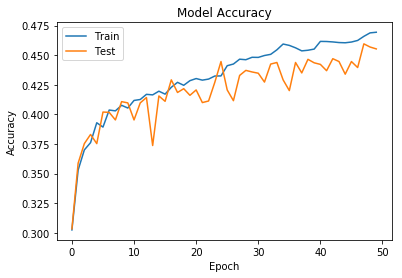

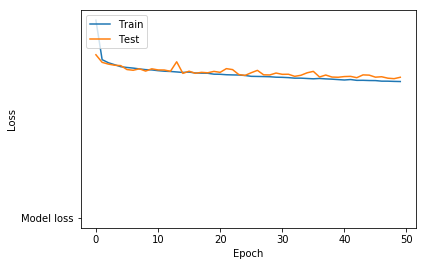

In [65]:
import matplotlib.pyplot as plt

model = create_neural_model(X_dummy)
history = model.fit(X_dummy, dummy_y, validation_split=0.25, epochs=50, batch_size=16, verbose=1)

#Accuracy plot
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

#Loss Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

In [83]:
y_pred = model.predict_classes(X_dummy)
print(y_pred)
print(y)
qwk = quadratic_weighted_kappa(y, y_pred)
print("QWK = ", qwk)

[1 4 2 ... 1 4 4]
[2 0 3 ... 3 4 3]
QWK =  0.45441142010850566


In [67]:
model.evaluate(X_dummy, dummy_y)

14993/14993 [==============================] - 0s 33us/step


[1.2367662726334032, 0.4701527379463618]

In [68]:
from sklearn.metrics import accuracy_score

accuracy_score(y, y_pred)

0.47015273794437407

In [69]:
confusion_matrix(y, y_pred)

[[7, 154, 84, 25, 140, 0, 0, 0, 0],
 [0, 954, 976, 210, 950, 0, 0, 0, 0],
 [1, 619, 1462, 557, 1398, 0, 0, 0, 0],
 [0, 227, 566, 1133, 1333, 0, 0, 0, 0],
 [2, 142, 316, 244, 3493, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_dummy, y, test_size=0.10, random_state=1337)

forest = RandomForestClassifier(random_state=1337, n_estimators=100)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1337, verbose=0,
            warm_start=False)

In [71]:
y_pred = forest.predict(X_test)
qwk = quadratic_weighted_kappa(y_test, y_pred)
print("QWK = ", qwk)

QWK =  0.45343379740676226


In [73]:
accuracy_score(y_test, y_pred)

0.5026666666666667

In [58]:
np.save('nnX.npy', X)
np.save('nny.npy', y)
np.save('nny_nummy.npy', dummy_y)

In [95]:
print(list(X))
print(X.dtypes)

['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'Sent_mag', 'Sent_score', 'main_breed_LifeExpectancy', 'second_breed_LifeExpectancy', 'StatePop', 'SateArea', 'PopDensity', 'AvgIncome', 'x_vertex_mean', 'x_vertex_sum', 'x_vertex_var', 'y_vertex_mean', 'y_vertex_sum', 'y_vertex_var', 'bounding_conf_mean', 'bounding_conf_sum', 'bounding_conf_var', 'bounding_imp_mean', 'bounding_imp_sum', 'bounding_imp_var', 'color_blue_mean', 'color_blue_sum', 'color_blue_var', 'color_green_mean', 'color_green_sum', 'color_green_var', 'color_red_mean', 'color_red_sum', 'color_red_var', 'color_score_mean', 'color_score_sum', 'color_score_var', 'color_pixel_mean', 'color_pixel_sum', 'color_pixel_var', 'has_name', 'breed_popularity', 'breed_popularity_2', 'RescuerID_COUNT', 'pure_breed', 'months_to_live', 'SVD_Description_0', 'SVD_Description_1', 'SVD_Descripti

In [75]:
imgfeatures = np.load('img_features_train.npy')
imgfeatures_flip = np.load('img_features_train_flipped.npy')

print(imgfeatures.shape)
print(dummy_y.shape)

(14993, 1024)
(14993, 5)


In [98]:
lowval = imgfeatures < 0.1
imgfeatures[lowval] = 0
print(imgfeatures[0])
imgfeatures[~np.all(imgfeatures == 0, axis=1)]
lowval = imgfeatures_flip < 0.1
imgfeatures_flip[lowval] = 0
print(imgfeatures_flip[0])
imgfeatures_flip[~np.all(imgfeatures_flip == 0, axis=1)]

print(imgfeatures_flip.shape)

[0.         0.         0.         ... 0.35835502 0.52739626 0.50588965]
[0. 0. 0. ... 0. 0. 0.]
(14993, 1024)


In [86]:
#X_dummy = pd.merge(X_dummy, pd.DataFrame(imgfeatures))
#X_dummy = pd.merge(X_dummy, imgfeatures_flip)

X_new = X_dummy.values
X_new.shape

X_new = np.concatenate((X_new, imgfeatures), axis=1)
X_new.shape

X_new = np.concatenate((X_new, imgfeatures_flip), axis=1)
X_new.shape

(14993, 2117)

In [118]:



model = create_neural_model(X_new)
history = model.fit(X_new, dummy_y, validation_split=0.25, epochs=50, batch_size=16, verbose=1)

#Accuracy plot
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

#Loss Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

Train on 11244 samples, validate on 3749 samples
Epoch 1/50
11244/11244 [==============================] - 6s 553us/step - loss: 3.2859 - acc: 0.3171 - val_loss: 1.3736 - val_acc: 0.3750
Epoch 2/50
 7936/11244 [====================>.........] - ETA: 1s - loss: 1.3987 - acc: 0.3601

KeyboardInterrupt: 

In [109]:
y_pred = model.predict_classes(X_new)
print(y_pred)
print(y)
qwk = quadratic_weighted_kappa(y, y_pred)
print("QWK = ", qwk)

[2 1 2 ... 4 4 3]
[2 0 3 ... 3 4 3]
QWK =  0.46250825544566543


In [91]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25, random_state=1337)

forest = RandomForestClassifier(random_state=1337, n_estimators=100)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1337, verbose=0,
            warm_start=False)

In [92]:
y_pred = forest.predict(X_test)
qwk = quadratic_weighted_kappa(y_test, y_pred)
print("QWK = ", qwk)

QWK =  0.3340327967071717


In [93]:
np.save('X_new.npy', X_new)

In [94]:
np.save('y.npy', y)

In [99]:
from sklearn.model_selection import StratifiedKFold

In [124]:
def run_network(X_train, y_train):
    n_splits = 5
    
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1337)
    oof_train = np.zeros((X_train.shape[0]))
    
    i = 0
    
    for train_idx, valid_idx in kf.split(X_train, y_train):
        
        X_tr = X_train[train_idx]
        X_val = X_train[valid_idx]
        
        y_tr = np_utils.to_categorical(y_train[train_idx])
        y_val = np_utils.to_categorical(y_train[valid_idx])
        
        model = create_neural_model(X_tr)
        history = model.fit(X_tr, y_tr, validation_data=(X_val, y_val), epochs=50, batch_size=16, verbose=1)

        #Accuracy plot
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train','Test'], loc='upper left')
        plt.show()
        
        valid_pred = model.predict_classes(X_val)
        
        oof_train[valid_idx] = valid_pred
        
        i += 1
    return model, oof_train

Train on 11993 samples, validate on 3000 samples
Epoch 1/50
11993/11993 [==============================] - 7s 608us/step - loss: 2.6540 - acc: 0.3213 - val_loss: 1.3817 - val_acc: 0.3723
Epoch 2/50
11993/11993 [==============================] - 5s 443us/step - loss: 1.3930 - acc: 0.3726 - val_loss: 1.3645 - val_acc: 0.3840
Epoch 3/50
11993/11993 [==============================] - 6s 486us/step - loss: 1.3609 - acc: 0.3865 - val_loss: 1.3507 - val_acc: 0.3957
Epoch 4/50
11993/11993 [==============================] - 6s 470us/step - loss: 1.3578 - acc: 0.3896 - val_loss: 1.3549 - val_acc: 0.3957
Epoch 5/50
11993/11993 [==============================] - 5s 456us/step - loss: 1.3392 - acc: 0.4006 - val_loss: 1.3346 - val_acc: 0.3957
Epoch 6/50
11993/11993 [==============================] - 5s 457us/step - loss: 1.3359 - acc: 0.4048 - val_loss: 1.3406 - val_acc: 0.4073
Epoch 7/50
11993/11993 [==============================] - 5s 457us/step - loss: 1.3236 - acc: 0.4131 - val_loss: 1.3292 - v

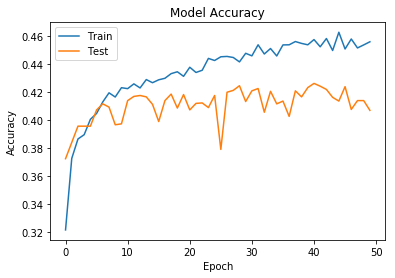

Train on 11993 samples, validate on 3000 samples
Epoch 1/50
11993/11993 [==============================] - 7s 589us/step - loss: 3.1103 - acc: 0.3023 - val_loss: 1.4022 - val_acc: 0.3630
Epoch 2/50
11993/11993 [==============================] - 6s 465us/step - loss: 1.3960 - acc: 0.3622 - val_loss: 1.3632 - val_acc: 0.3903
Epoch 3/50
11993/11993 [==============================] - 5s 452us/step - loss: 1.3828 - acc: 0.3738 - val_loss: 1.3538 - val_acc: 0.3963
Epoch 4/50
11993/11993 [==============================] - 5s 451us/step - loss: 1.3740 - acc: 0.3780 - val_loss: 1.3669 - val_acc: 0.3833
Epoch 5/50
11993/11993 [==============================] - 6s 479us/step - loss: 1.3615 - acc: 0.3910 - val_loss: 1.3659 - val_acc: 0.3823
Epoch 6/50
11993/11993 [==============================] - 6s 480us/step - loss: 1.3523 - acc: 0.3926 - val_loss: 1.3387 - val_acc: 0.3913
Epoch 7/50
11993/11993 [==============================] - 6s 469us/step - loss: 1.3511 - acc: 0.3943 - val_loss: 1.3269 - v

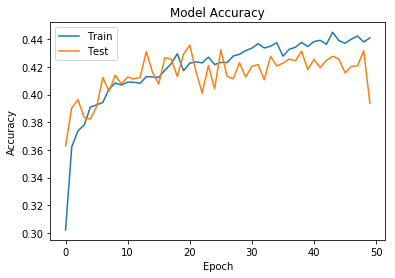

Train on 11995 samples, validate on 2998 samples
Epoch 1/50
11995/11995 [==============================] - 7s 609us/step - loss: 3.2302 - acc: 0.2836 - val_loss: 1.4396 - val_acc: 0.3289
Epoch 2/50
11995/11995 [==============================] - 6s 471us/step - loss: 1.4240 - acc: 0.3375 - val_loss: 1.3708 - val_acc: 0.3742
Epoch 3/50
11995/11995 [==============================] - 6s 472us/step - loss: 1.3962 - acc: 0.3586 - val_loss: 1.3465 - val_acc: 0.3873
Epoch 4/50
11995/11995 [==============================] - 6s 480us/step - loss: 1.3866 - acc: 0.3652 - val_loss: 1.3556 - val_acc: 0.3936
Epoch 5/50
11995/11995 [==============================] - 6s 487us/step - loss: 1.3824 - acc: 0.3627 - val_loss: 1.3484 - val_acc: 0.3853
Epoch 6/50
11995/11995 [==============================] - 6s 483us/step - loss: 1.3766 - acc: 0.3639 - val_loss: 1.3355 - val_acc: 0.3966
Epoch 7/50
11995/11995 [==============================] - 6s 479us/step - loss: 1.3729 - acc: 0.3651 - val_loss: 1.3330 - v

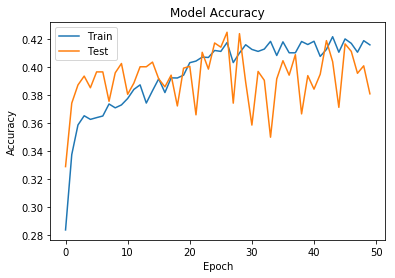

Train on 11995 samples, validate on 2998 samples
Epoch 1/50
11995/11995 [==============================] - 7s 612us/step - loss: 2.7565 - acc: 0.3108 - val_loss: 1.3903 - val_acc: 0.3803
Epoch 2/50
11995/11995 [==============================] - 6s 472us/step - loss: 1.3946 - acc: 0.3659 - val_loss: 1.3514 - val_acc: 0.3886
Epoch 3/50
11995/11995 [==============================] - 6s 466us/step - loss: 1.3740 - acc: 0.3753 - val_loss: 1.3587 - val_acc: 0.3963
Epoch 4/50
11995/11995 [==============================] - 6s 475us/step - loss: 1.3614 - acc: 0.3901 - val_loss: 1.3460 - val_acc: 0.4026
Epoch 5/50
11995/11995 [==============================] - 6s 474us/step - loss: 1.3461 - acc: 0.3961 - val_loss: 1.3290 - val_acc: 0.4136
Epoch 6/50
11995/11995 [==============================] - 6s 468us/step - loss: 1.3426 - acc: 0.4008 - val_loss: 1.3324 - val_acc: 0.4173
Epoch 7/50
11995/11995 [==============================] - 6s 505us/step - loss: 1.3414 - acc: 0.4014 - val_loss: 1.3421 - v

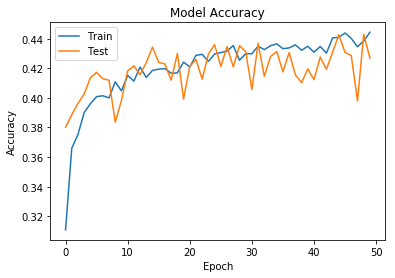

Train on 11996 samples, validate on 2997 samples
Epoch 1/50
11996/11996 [==============================] - 7s 602us/step - loss: 2.1115 - acc: 0.3049 - val_loss: 1.4139 - val_acc: 0.3470
Epoch 2/50
11996/11996 [==============================] - 6s 472us/step - loss: 1.3987 - acc: 0.3558 - val_loss: 1.3632 - val_acc: 0.3827
Epoch 3/50
11996/11996 [==============================] - 6s 486us/step - loss: 1.3713 - acc: 0.3796 - val_loss: 1.3524 - val_acc: 0.3974
Epoch 4/50
11996/11996 [==============================] - 6s 511us/step - loss: 1.3626 - acc: 0.3810 - val_loss: 1.3805 - val_acc: 0.3817
Epoch 5/50
11996/11996 [==============================] - 6s 485us/step - loss: 1.3534 - acc: 0.3910 - val_loss: 1.3393 - val_acc: 0.4074
Epoch 6/50
11996/11996 [==============================] - 6s 479us/step - loss: 1.3463 - acc: 0.3934 - val_loss: 1.5076 - val_acc: 0.3620
Epoch 7/50
11996/11996 [==============================] - 6s 471us/step - loss: 1.3406 - acc: 0.4006 - val_loss: 1.3320 - v

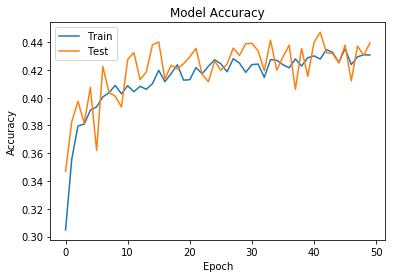

QWK =  0.38435851595933945


In [125]:
model, oof_train = run_network(X_new, y)
qwk = quadratic_weighted_kappa(y, oof_train)
print("QWK = ", qwk)

In [126]:
from sklearn.model_selection import cross_val_score
from sklearn import svm

clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, y.reshape(-1,1), oof_train.reshape(-1,1), cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Accuracy: 0.48 (+/- 0.01)


In [129]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1337)
res = np.zeros(5)
i = 0
for train_idx, valid_idx in kf.split(X_train, y_train):
    res[i] = quadratic_weighted_kappa(y[valid_idx], oof_train[valid_idx])
    i += 1

In [130]:
print("Accuracy: %0.2f (+/- %0.2f)" % (res.mean(), res.std() * 2))

Accuracy: 0.38 (+/- 0.04)


In [161]:
import random
def random_numbs(n, c):
    choice = range(c)
    return np.unique(np.random.choice(choice, n, True)).shape[0]

count = 0
for i in range(1000000):
    if random_numbs(21, 4) == 4:
        count += 1
        
print(count/1000000)

0.990526


0.622602
